In [1]:
%reload_ext autoreload

import os
import sys
import random

import torch
import numpy as np
import matplotlib.pyplot as plt

# Append python path - needed to import text_recognizer
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

/Users/niall.turbitt/opt/anaconda3/envs/text-recognizer/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

import text_recognizer.data
import text_recognizer.models
import text_recognizer.lit_models

from text_recognizer.metadata.iam_paragraphs import IMAGE_HEIGHT, IMAGE_WIDTH


### IAM Paragraphs dataset

In [6]:
iam_paragraphs = text_recognizer.data.IAMParagraphs()

iam_paragraphs.prepare_data()
iam_paragraphs.setup()
x, y = next(iter(iam_paragraphs.val_dataloader()))

iam_paragraphs

IAMParagraphs.setup(None): Loading IAM paragraph regions and lines...


IAM Paragraphs Dataset
Num classes: 84
Input dims : (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 1087, 220, 232
Train Batch x stats: (torch.Size([128, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0249), tensor(0.0781), tensor(1.))
Train Batch y stats: (torch.Size([128, 682]), torch.int64, tensor(1), tensor(83))
Test Batch x stats: (torch.Size([128, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0278), tensor(0.0843), tensor(0.9373))
Test Batch y stats: (torch.Size([128, 682]), torch.int64, tensor(1), tensor(83))

<S>The East Anglian behaviour (see p. 82)
has always differed from that of the
summer fisheries. There is the "swim"
at slack waters, even in daylight
sometimes; and the high swimming,
when fish are caught only in the top
few yards of netting. These and other
fascinating behaviour mysteries are peculiar
to this fishery, which unfortunately seems
to be dying out; but a full discussion of
them is beyond the present scope.<E>


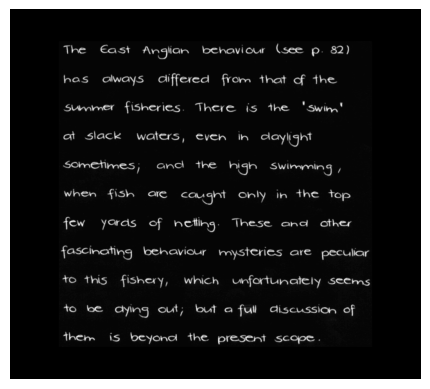

In [4]:
def show(y):
    y = y.detach().cpu()  # bring back from accelerator if it's being used
    return "".join(np.array(iam_paragraphs.mapping)[y]).replace("<P>", "")

idx = random.randint(0, len(x))

print(show(y[idx]))
plt.imshow(x[idx].view(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='Greys_r')
plt.axis("off");

### ResNet Transformer

In [5]:
rnt = text_recognizer.models.ResnetTransformer(data_config=iam_paragraphs.config())

In [6]:
# Cast to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

rnt.to(device); x = x.to(device); y = y.to(device);

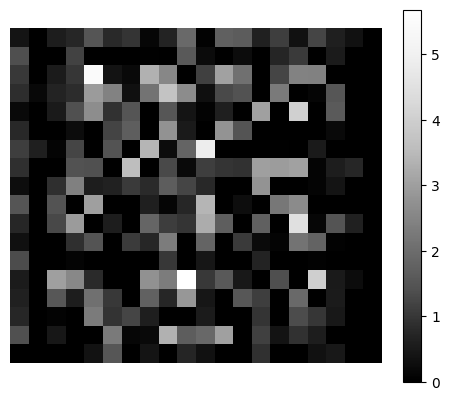

In [7]:
# Pass single input through encoder

# ResNet is designed for RGB images, replicate the input across channels 3 times
resnet_embedding, = rnt.resnet(x[idx:idx+1].repeat(1, 3, 1, 1))

resnet_idx = random.randint(0, len(resnet_embedding))  # re-execute to view a different channel
plt.matshow(resnet_embedding[resnet_idx].detach().cpu(), cmap="Greys_r");
plt.axis("off"); plt.colorbar(fraction=0.05);

In [27]:
preds, = rnt(x[idx:idx+1])

<S>d/ddNGddYrdaddVdVdVENdNVdVdddddhhddNrdVddddhdddNdddNdddVdYdVNdNVFVdVddVddNVddNdF/ddGdddddEdYYddNYddGddddFadVdbdddddddNdahdddddd?dNNVdFdNNd?dddaadhddddddhdhdVddE#dVdddddNVdhdYrVdNddNgddNdVYdhddddEdVddVVddVddddNGddNddddddddd/dVddNddddddVFdVddVddddNdgVdVddddaVVddddNNNVddaVhddddNdddVddVdNVdrddEYdVdddVdddddbddrdVddaFFdVddddVdddVdrddddddVdddardhddddNdddVrdNEhVddhrdZdVNdddVVhddddddddNddddhNdVddrhdNdEddhdddrdddNddVrVddddVdddVddddNVdddddddddddrdddddrdddhhddddVNdNddddGddddddd//rGddVddNddErhGYFFdNaEFddddrddhYdF3NdhV+dddEdddddVhddddhhddddddgddVdddrrVhddNdadNddddddN/dddNGddaNNdEdrbdVdNNddddddddhdddVNdFdNdhNddVd4ddddVddNdddddEdEdVFddVraVddGVdddFdddVFdNdVVErddddNVdddddGFVVhNNNddYdddddddd


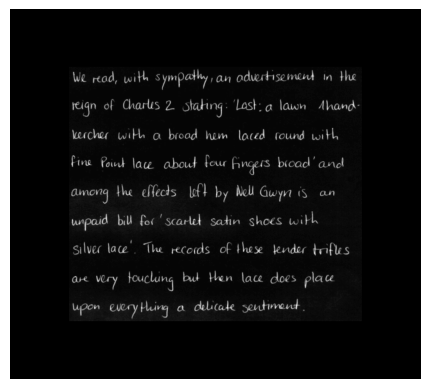

In [32]:
# Prediction from untrained model
print(show(preds.cpu()))
plt.imshow(x[idx].view(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='Greys_r')
plt.axis("off");

### TransformerLitModel

In [8]:
import text_recognizer.lit_models

lit_rnt = text_recognizer.lit_models.TransformerLitModel(rnt)

In [8]:
forcing_outs, = lit_rnt.teacher_forward(x[idx:idx+1], y[idx:idx+1])

b5?F4?DF4??4?CxV??Vb??44C?V4?V?x?4?VV???????:44???C44w??4?4?;???4C?x44?bV4bb?4444CCF???4?C?b?4?4C??44?F???4b4??4F;;FVb?VC4??bV4???F?TTVUV???;F?VMF???4V??C??4F?V?4?xb?FF?4?CbC????4VCF???4U?44??FF??b44?b???FVC444?4?V??V?V7Vb7V:4?V4bx4V4;?4?4b?4;?Fb4?4?V?x?b4?4bF?C4?F?x?????x?bbbF??C???4FF??????V4F??VCbWV?CbF7UC??b?FV?C?4C?b???b?4?V??44?4?VUbWCC4?7?44CTx?xbVV44?bV??444FV?x?4F?x;??444x4?4?CC?4?444xx4?7?xF4;V??bC4Cx???FV??x?b??xV?T44?4V4?bb???xb;C444;??444?????V?4b????W4?xb?C?U?V?FF4?F?b4??CC4???4b????bbd?4FV??F????4?x???F4?U4??4:44?C?x44CWb??CFF???CC???FC4??V4?;??;C4???4C?F4???C?;4??CV?4?xxdVF??bCx?44W4x4?44????V?4F444???4????4V???4??744?F4?4;?bF4???4b4??4F4FF4D4bb?F4?bVb4b?444


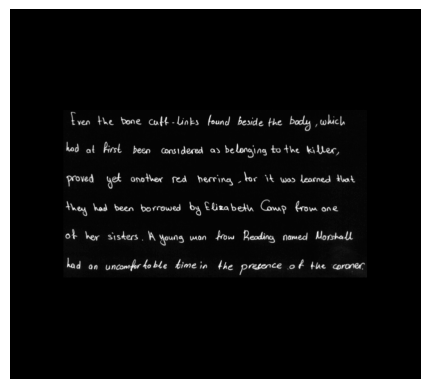

In [9]:
forcing_preds = torch.argmax(forcing_outs, dim=0)

print(show(forcing_preds.cpu()))
plt.imshow(x[idx].view(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='Greys_r')
plt.axis("off");

### Run Experiment - ResNet Transformer - IAM Paragraphs

In [2]:
%run ../training/run_experiment.py --data_class IAMParagraphs --model_class ResnetTransformer --loss transformer \
  --fast_dev_run True --log_every_n_steps 1 --limit_test_batches 0 \
  --max_epochs 1 --batch_size 16 --precision 16 \
  --limit_train_batches 10 --limit_test_batches 1 --limit_val_batches 2

/Users/niall.turbitt/opt/anaconda3/envs/text-recognizer/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:702: UserWarning: You passed `Trainer(accelerator='cpu', precision=16)` but native AMP is not supported on CPU. Using `precision='bf16'` instead.
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
IAMParagraphs.setup(fit): Loading IAM paragraph regions and lines...


Namespace(logger=True, enable_checkpointing=True, default_root_dir=None, gradient_clip_val=None, gradient_clip_algorithm=None, num_nodes=1, num_processes=None, devices=None, gpus=None, auto_select_gpus=False, tpu_cores=None, ipus=None, enable_progress_bar=True, overfit_batches=0.0, track_grad_norm=-1, check_val_every_n_epoch=1, fast_dev_run=True, accumulate_grad_batches=None, max_epochs=1, min_epochs=None, max_steps=-1, min_steps=None, max_time=None, limit_train_batches=10, limit_val_batches=2, limit_test_batches=1, limit_predict_batches=None, val_check_interval=None, log_every_n_steps=1, accelerator=None, strategy=None, sync_batchnorm=False, precision=16, enable_model_summary=True, num_sanity_val_steps=2, resume_from_checkpoint=None, profiler=None, benchmark=None, deterministic=None, reload_dataloaders_every_n_epochs=0, auto_lr_find=False, replace_sampler_ddp=True, detect_anomaly=False, auto_scale_batch_size=False, plugins=None, amp_backend='native', amp_level=None, move_metrics_to_cp


   | Name                      | Type                    | Params
-----------------------------------------------------------------------
0  | model                     | ResnetTransformer       | 14.0 M
1  | model.resnet              | Sequential              | 11.2 M
2  | model.encoder_projection  | Conv2d                  | 131 K 
3  | model.enc_pos_encoder     | PositionalEncodingImage | 0     
4  | model.embedding           | Embedding               | 21.5 K
5  | model.fc                  | Linear                  | 21.6 K
6  | model.dec_pos_encoder     | PositionalEncoding      | 0     
7  | model.transformer_decoder | TransformerDecoder      | 2.6 M 
8  | train_acc                 | MulticlassAccuracy      | 0     
9  | val_acc                   | MulticlassAccuracy      | 0     
10 | test_acc                  | MulticlassAccuracy      | 0     
11 | val_cer                   | CharacterErrorRate      | 0     
12 | test_cer                  | CharacterErrorRate      | 0     
13 

Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 

AttributeError: 'TransformerLitModel' object has no attribute 'is_logged_batch'